In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy import optimize
import openpyxl
from sklearn.preprocessing import StandardScaler
import torch



datos = pd.read_csv(r'cleaned_data.csv')
datos.head()
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17976 entries, 0 to 17975
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  17976 non-null  int64  
 1   Player      17976 non-null  object 
 2   Ht          17976 non-null  object 
 3   Wt          17976 non-null  float64
 4   Colleges    17976 non-null  object 
 5   Pos         17976 non-null  object 
 6   Age         17976 non-null  int64  
 7   Tm          17976 non-null  object 
 8   G           17976 non-null  int64  
 9   GS          17976 non-null  int64  
 10  MP          17976 non-null  float64
 11  FG          17976 non-null  float64
 12  FGA         17976 non-null  float64
 13  FG%         17976 non-null  float64
 14  3P          17976 non-null  float64
 15  3PA         17976 non-null  float64
 16  3P%         17976 non-null  float64
 17  2P          17976 non-null  float64
 18  2PA         17976 non-null  float64
 19  2P%         17976 non-nul

In [2]:
variables = datos.columns.tolist()

print(datos['Pos'].dtypes)

# Seleccionar las columnas numéricas del DataFrame
numericas = datos.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64']).columns

# Seleccionar las columnas categóricas del DataFrame
categoricas = [variable for variable in variables if variable not in numericas]

# Valores perdidos
missing = datos.isna().mean().sort_values(ascending=False) * 100



object


In [3]:
categoricasANumericas = ["Ht"]
for var in categoricasANumericas:
    datos[var] = datos[var].str.replace('-', '.').astype(float)

#Porcentajes fuera de rango
columnas_corregir_porcentajes = [
    "W/L%", "FT%", "eFG%", "2P%", "3P%",
]
for col in columnas_corregir_porcentajes:
    datos[col] = [x if 0 <= x <= 100 else np.nan for x in datos[col]]

#Valores extraños en variables numéricas
for col in numericas:
    datos[col] = [x if 0 <= x <= 9999 else np.nan for x in datos[col]]

# Descriptivos variables numéricas mediante función describe() de Python
descriptivos_num = datos.describe().T

# Simplificar columna posicion para que cada jugador solo tenga una posición
datos["Pos"] = datos["Pos"].str.split("-").str[0].str.strip()

# Añadimos más descriptivos a los anteriores
for num in numericas:
    descriptivos_num.loc[num, "Asimetria"] = datos[num].skew()
    descriptivos_num.loc[num, "Kurtosis"] = datos[num].kurtosis()
    descriptivos_num.loc[num, "Rango"] = np.ptp(datos[num].dropna().values)

In [4]:
# Mirar outliers
outliers = {}
for col in numericas:
    q1 = datos[col].quantile(0.25)
    q3 = datos[col].quantile(0.75)
    iqr = q3 - q1
    outliers[col] = ((datos[col] < q1 - 1.5*iqr) | 
                     (datos[col] > q3 + 1.5*iqr)).sum()
    


In [5]:
#Crear variable MVP por cada año del dataset

datos['Share'] = pd.to_numeric(datos['Share'], errors='coerce')
datos['MVP'] = 0
datos['MVP'] = (
    datos.groupby('Year')['Share']
         .transform(lambda x: x == x.max())
         .astype(int)
)


# Mostrar todos los MVPs 
# Seleccionar todos los jugadores marcados como MVP
mvps = datos.loc[datos['MVP'] == 1, ['Year', 'Player', 'Team', 'Share', 'MVP']]

# Ordenar por año
mvps = mvps.sort_values('Year')

# Mostrar resultados
print("Listado de MVPs por temporada:")
print(mvps)


Listado de MVPs por temporada:
         Year                 Player                    Team  Share  MVP
75     1980.0    Kareem Abdul-Jabbar      Los Angeles Lakers  0.665    1
16999  1981.0          Julius Erving      Philadelphia 76ers  0.658    1
17779  1982.0           Moses Malone         Houston Rockets  0.735    1
17017  1983.0           Moses Malone      Philadelphia 76ers  0.960    1
2100   1984.0             Larry Bird          Boston Celtics  0.858    1
2113   1985.0             Larry Bird          Boston Celtics  0.978    1
2126   1986.0             Larry Bird          Boston Celtics  0.981    1
175    1987.0          Magic Johnson      Los Angeles Lakers  0.940    1
15504  1988.0         Michael Jordan           Chicago Bulls  0.831    1
202    1989.0          Magic Johnson      Los Angeles Lakers  0.782    1
15999  1990.0          Magic Johnson      Los Angeles Lakers  0.691    1
7457   1991.0         Michael Jordan           Chicago Bulls  0.928    1
7469   1992.0       

     indice_produccion  indice_eficiencia  indice_disponibilidad
Age                                                             
18           -1.875609          -0.760257              -1.968753
19           -0.033281          -0.604220              -0.064722
20            0.276660          -0.332750               0.204443
21            0.467573          -0.333635               0.269192
22            0.005462          -0.357436              -0.088886


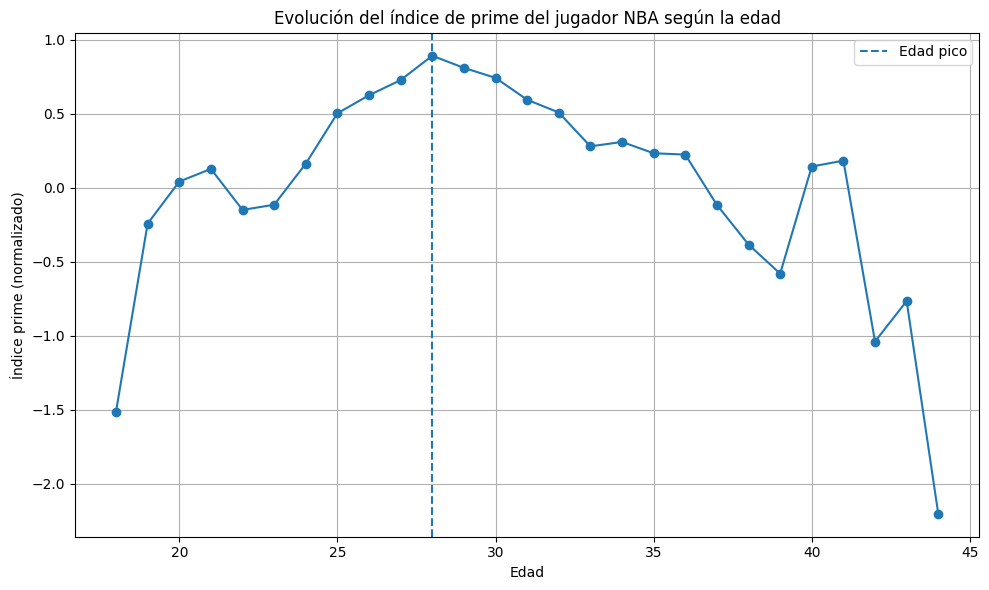


Edad de máximo rendimiento (prime):
28


In [6]:
# Mirar la eficiencia de cada jugador con respecto a la edad para estudiar cuando es el "prime" de un jugador
def calcular_prime(datos):
    stats_produccion = ['PTS', 'FGA', 'FG', 'AST', 'TRB']
    stats_eficiencia = ['FG%', 'eFG%', 'W/L%']
    stats_disponibilidad = ['G', 'MP']
    stats_clave = (
        ['Age'] +
        stats_produccion +
        stats_eficiencia +
        stats_disponibilidad
    )

    # print("Estadísticas clave seleccionadas para el análisis por edad:")
    # print(stats_clave)
    datos_edad = datos[stats_clave].copy()
    datos_edad = datos_edad.dropna(subset=['Age'])

    # print("\nDimensiones del dataset tras filtrar columnas y edad:")
    # print(datos_edad.shape)

    edad_mean = datos_edad.groupby('Age').mean()

    # print("\nPrimeras filas del dataset agregado por edad:")
    # print(edad_mean.head())

    edad_df = edad_mean.copy()

    scaler = StandardScaler()

    cols_indice = [
        'PTS', 'FGA', 'FG', 'AST', 'TRB',
        'FG%', 'eFG%', 'W/L%',
        'G', 'MP'
    ]

    edad_df_z = edad_df.copy()
    edad_df_z[cols_indice] = scaler.fit_transform(edad_df[cols_indice])

    # print("\nEjemplo de variables normalizadas:")
    # print(edad_df_z[cols_indice].head())

    edad_df_z['indice_produccion'] = edad_df_z[
        ['PTS', 'FGA', 'FG', 'AST', 'TRB']
    ].mean(axis=1)

    edad_df_z['indice_eficiencia'] = edad_df_z[
        ['FG%', 'eFG%', 'W/L%']
    ].mean(axis=1)

    edad_df_z['indice_disponibilidad'] = edad_df_z[
        ['G', 'MP']
    ].mean(axis=1)

    # print("\nSubíndices calculados (primeras edades):")
    print(
        edad_df_z[
            ['indice_produccion', 'indice_eficiencia', 'indice_disponibilidad']
        ].head()
    )

    edad_df_z['indice_prime_edad'] = (
        0.35 * edad_df_z['indice_produccion'] +
        0.35 * edad_df_z['indice_eficiencia'] +
        0.30 * edad_df_z['indice_disponibilidad']
    )

    return edad_df_z

edad_df_z = calcular_prime(datos)

plt.figure(figsize=(10, 6))
plt.plot(
    edad_df_z.index,
    edad_df_z['indice_prime_edad'],
    marker='o'
)
plt.axvline(
    edad_df_z['indice_prime_edad'].idxmax(),
    linestyle='--',
    label='Edad pico'
)
plt.title("Evolución del índice de prime del jugador NBA según la edad")
plt.xlabel("Edad")
plt.ylabel("Índice prime (normalizado)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nEdad de máximo rendimiento (prime):")
print(edad_df_z['indice_prime_edad'].idxmax())



     indice_produccion  indice_eficiencia  indice_disponibilidad
Age                                                             
18           -1.289023          -1.735363              -1.346633
19            0.632550          -0.389257               0.464492
20            1.293646          -0.168807               0.434095
21            1.203270          -0.197103               0.843971
22           -0.118494          -0.781564              -0.218237
     indice_produccion  indice_eficiencia  indice_disponibilidad
Age                                                             
19            1.256033          -0.703531               0.571331
20            1.475143           0.471344               0.916959
21            0.071208          -0.604249              -0.589425
22           -1.251709          -1.112668              -1.585442
23           -0.920433          -0.812788              -1.188185
     indice_produccion  indice_eficiencia  indice_disponibilidad
Age                      

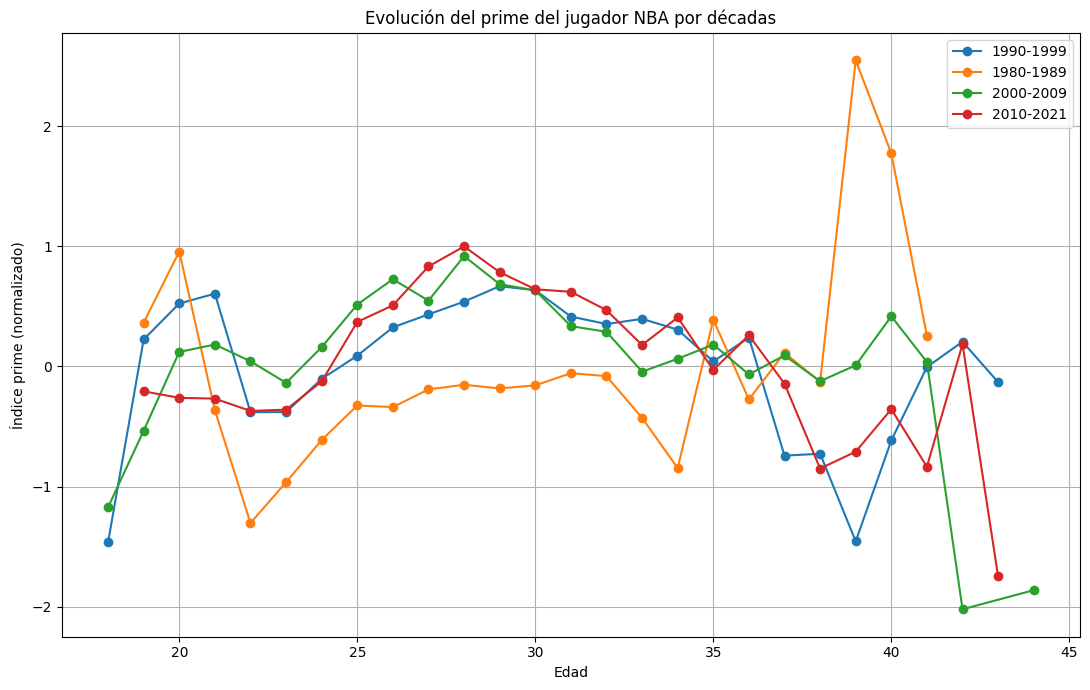


Edad de máximo rendimiento por década:
           Edad_prime
1990-1999          29
1980-1989          39
2000-2009          28
2010-2021          28


In [7]:
# Rendimiento de jugador por décadas
def asignar_decada(year):
    if 1980 <= year <= 1989:
        return '1980-1989'
    elif 1990 <= year <= 1999:
        return '1990-1999'
    elif 2000 <= year <= 2009:
        return '2000-2009'
    elif 2010 <= year <= 2021:
        return '2010-2021'
    else:
        return np.nan

datos['Decada'] = datos['Year'].apply(asignar_decada)

stats_indice = [
    'Age',
    'PTS', 'FGA', 'FG', 'AST', 'TRB',
    'FG%', 'eFG%', 'W/L%',
    'G', 'MP',
    'Decada'
]

datos_decadas = datos[stats_indice].dropna(subset=['Age', 'Decada'])




prime_por_decada = {}

for decada in datos_decadas['Decada'].unique():
    df_dec = datos_decadas[datos_decadas['Decada'] == decada]
    prime_por_decada[decada] = calcular_prime(df_dec)

plt.figure(figsize=(11, 7))

for decada, df_prime in prime_por_decada.items():
    plt.plot(
        df_prime.index,
        df_prime['indice_prime_edad'],
        marker='o',
        label=decada
    )

plt.title("Evolución del prime del jugador NBA por décadas")
plt.xlabel("Edad")
plt.ylabel("Índice prime (normalizado)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


edad_pico_decadas = {
    decada: df['indice_prime_edad'].idxmax()
    for decada, df in prime_por_decada.items()
}

edad_pico_df = pd.DataFrame.from_dict(
    edad_pico_decadas,
    orient='index',
    columns=['Edad_prime']
)

print("\nEdad de máximo rendimiento por década:")
print(edad_pico_df)

# Explicar en la memoria del TFM la anomalía con lá decada de los 80 por el caso de Kareem, ya que es el único jugador de su edad 
# Con unos números muy impactantes. Una solución podría ser limitar el dataset hasta una edad determinada, pero no creo que sea bueno


In [8]:
# Comprobar los valores únicos de posición
print("Posiciones únicas encontradas:")
print(datos['Pos'].unique())

# Seleccionar columnas necesarias para el índice por posición
cols_pos = [
    'Pos', 'Decada',
    'PTS', 'FGA', 'FG', 'AST', 'TRB',
    'FG%', 'eFG%', 'W/L%',
    'G', 'MP'
]

datos_pos = datos[cols_pos].dropna(subset=['Pos', 'Decada'])
print("\nDimensiones del dataset preparado para análisis por posición:")
print(datos_pos.shape)



Posiciones únicas encontradas:
['PF' 'SG' 'C' 'SF' 'PG']

Dimensiones del dataset preparado para análisis por posición:
(17976, 12)



Columnas usadas para índice prime por posición:
['PTS', 'FGA', 'FG', 'AST', 'TRB', 'FG%', 'eFG%', 'W/L%', 'G', 'MP']

Primeras filas del índice prime por posición:
     indice_prime_posicion
Pos                       
C                -0.250285
PF               -0.216579
PG                0.090049
SF                0.364822
SG                0.011993


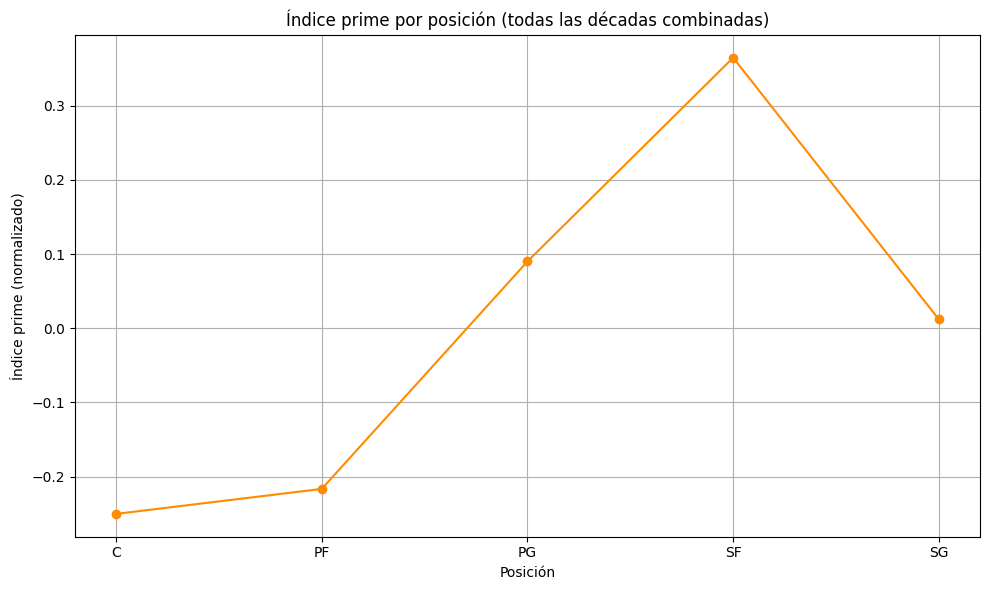

In [9]:
#Prime por posicion
def calcular_prime_por_posicion(df):
    """
    Calcula el índice prime por posición.
    """
    cols_modelo = [
        'PTS', 'FGA', 'FG', 'AST', 'TRB',
        'FG%', 'eFG%', 'W/L%',
        'G', 'MP'
    ]
    
    # Media por posición
    pos_mean = df.groupby('Pos')[cols_modelo].mean()
    
    print("\nColumnas usadas para índice prime por posición:")
    print(pos_mean.columns.tolist())
    
    # Normalización
    scaler = StandardScaler()
    pos_z = pos_mean.copy()
    pos_z[cols_modelo] = scaler.fit_transform(pos_mean[cols_modelo])
    
    # Subíndices
    pos_z['indice_produccion'] = pos_z[['PTS', 'FGA', 'FG', 'AST', 'TRB']].mean(axis=1)
    pos_z['indice_eficiencia'] = pos_z[['FG%', 'eFG%', 'W/L%']].mean(axis=1)
    pos_z['indice_disponibilidad'] = pos_z[['G', 'MP']].mean(axis=1)
    
    # Índice final
    pos_z['indice_prime_posicion'] = (
        0.35 * pos_z['indice_produccion'] +
        0.35 * pos_z['indice_eficiencia'] +
        0.30 * pos_z['indice_disponibilidad']
    )
    
    print("\nPrimeras filas del índice prime por posición:")
    print(pos_z[['indice_prime_posicion']].head())
    
    return pos_z

prime_pos_global = calcular_prime_por_posicion(datos_pos)
plt.figure(figsize=(10, 6))
plt.plot(
    prime_pos_global.index,
    prime_pos_global['indice_prime_posicion'],
    marker='o',
    linestyle='-',
    color='darkorange'
)
plt.title("Índice prime por posición (todas las décadas combinadas)")
plt.xlabel("Posición")
plt.ylabel("Índice prime (normalizado)")
plt.grid(True)
plt.tight_layout()
plt.show()



Columnas usadas para índice prime por posición:
['PTS', 'FGA', 'FG', 'AST', 'TRB', 'FG%', 'eFG%', 'W/L%', 'G', 'MP']

Primeras filas del índice prime por posición:
     indice_prime_posicion
Pos                       
C                -0.736828
PF                0.173025
PG                0.142975
SF                0.800880
SG               -0.380053

Década 1990-1999 → posición con mayor índice prime:
SF

Columnas usadas para índice prime por posición:
['PTS', 'FGA', 'FG', 'AST', 'TRB', 'FG%', 'eFG%', 'W/L%', 'G', 'MP']

Primeras filas del índice prime por posición:
     indice_prime_posicion
Pos                       
C                 0.382243
PF               -0.202210
PG               -0.048798
SF                0.035954
SG               -0.167189

Década 1980-1989 → posición con mayor índice prime:
C

Columnas usadas para índice prime por posición:
['PTS', 'FGA', 'FG', 'AST', 'TRB', 'FG%', 'eFG%', 'W/L%', 'G', 'MP']

Primeras filas del índice prime por posición:
     indice_prim

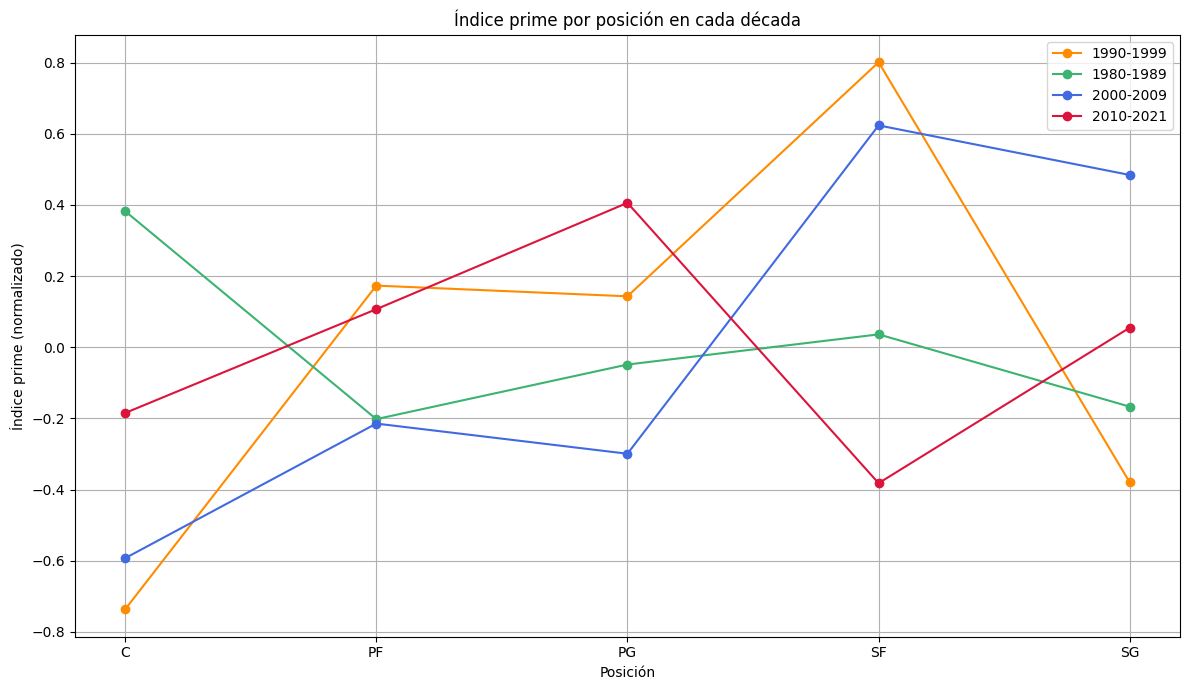

In [10]:
#Prime por posicion y decada

prime_pos_por_decada = {}

for decada in datos_pos['Decada'].unique():
    df_dec = datos_pos[datos_pos['Decada'] == decada]
    prime_pos_por_decada[decada] = calcular_prime_por_posicion(df_dec)
    
    print(f"\nDécada {decada} → posición con mayor índice prime:")
    print(prime_pos_por_decada[decada]['indice_prime_posicion'].idxmax())

plt.figure(figsize=(12, 7))

colores = ['darkorange', 'mediumseagreen', 'royalblue', 'crimson']  # un color por década
for i, (decada, df_prime) in enumerate(prime_pos_por_decada.items()):
    plt.plot(
        df_prime.index,
        df_prime['indice_prime_posicion'],
        marker='o',
        linestyle='-',
        color=colores[i],
        label=decada
    )

plt.title("Índice prime por posición en cada década")
plt.xlabel("Posición")
plt.ylabel("Índice prime (normalizado)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Número total de MVPs en el dataset:
42

Primeros 5 MVPs:
                   Player    Year                   Team Pos  Age  MVP   PTS  \
75    Kareem Abdul-Jabbar  1980.0     Los Angeles Lakers   C   32    1  24.8   
175         Magic Johnson  1987.0     Los Angeles Lakers  PG   27    1  23.9   
202         Magic Johnson  1989.0     Los Angeles Lakers  PG   29    1  22.5   
652     Russell Westbrook  2017.0  Oklahoma City Thunder  PG   28    1  31.6   
1318         Kevin Durant  2014.0  Oklahoma City Thunder  SF   25    1  32.0   

       FGA    FG   AST   TRB    FG%   eFG%   W/L%   G    MP  
75    16.9  10.2   4.5  10.8  0.604  0.604  0.732  82  38.3  
175   16.4   8.5  12.2   6.3  0.522  0.525  0.793  80  36.3  
202   14.8   7.5  12.8   7.9  0.509  0.535  0.695  77  37.5  
652   24.0  10.2  10.4  10.7  0.425  0.476  0.573  81  34.6  
1318  20.8  10.5   5.5   7.4  0.503  0.560  0.720  81  38.5  

Comparativa de estadísticas (MVP=1 vs MVP=0):
           PTS        FGA        FG       

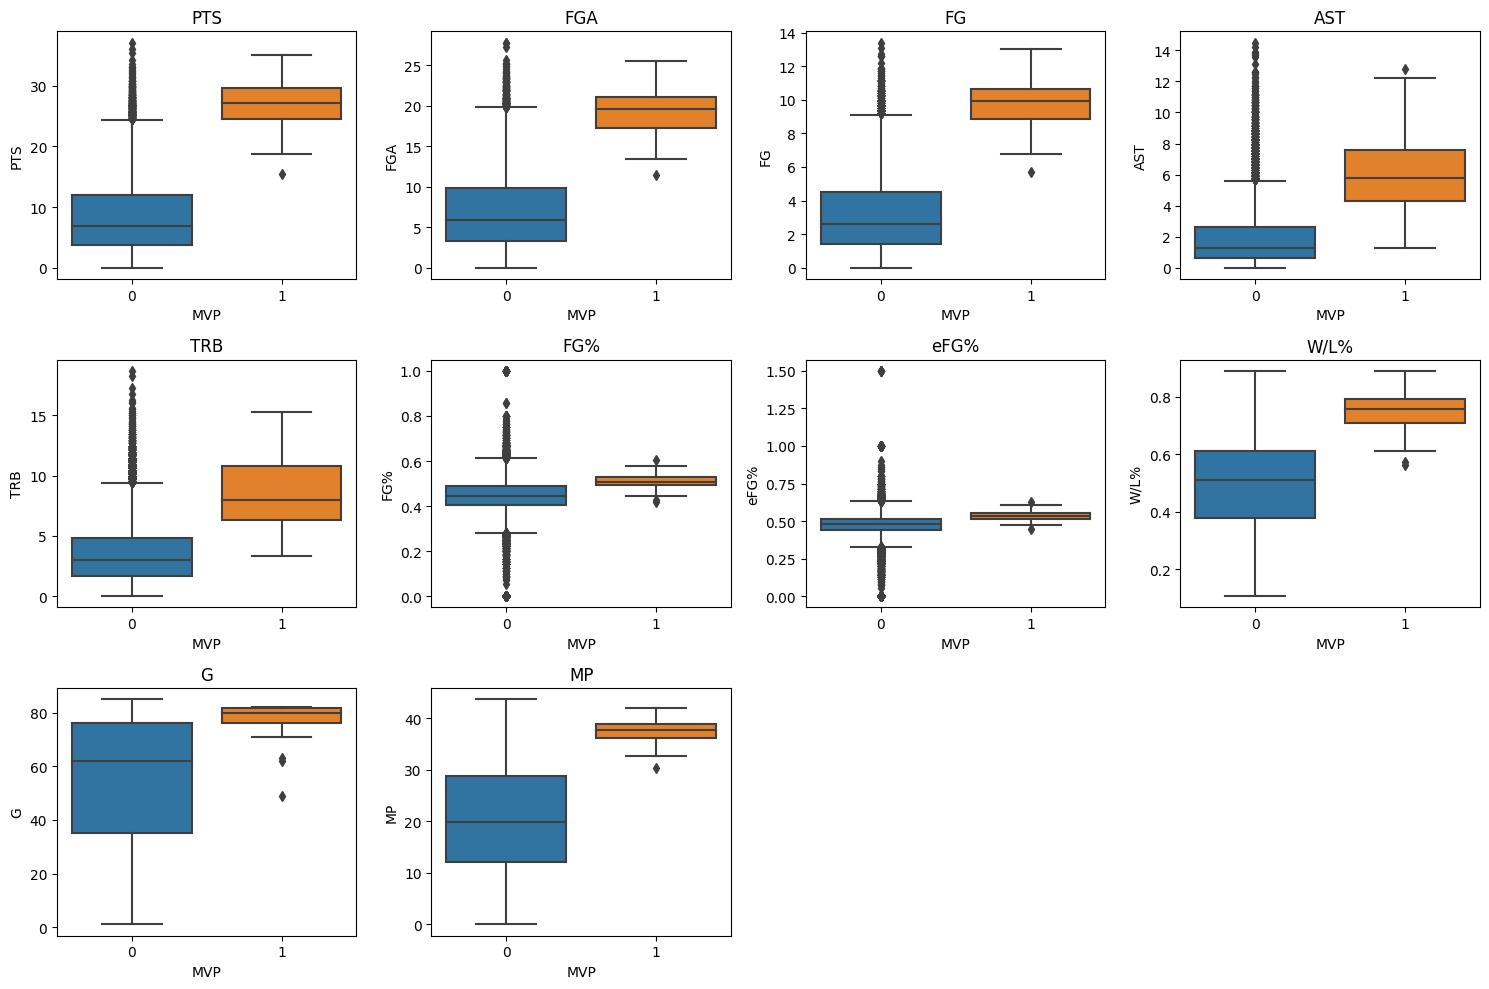


Boxplots de estadísticas comparando MVP vs no MVP generados correctamente.

Número de MVPs por posición:
Pos
PF    11
PG     9
SG     8
C      7
SF     7
Name: count, dtype: int64


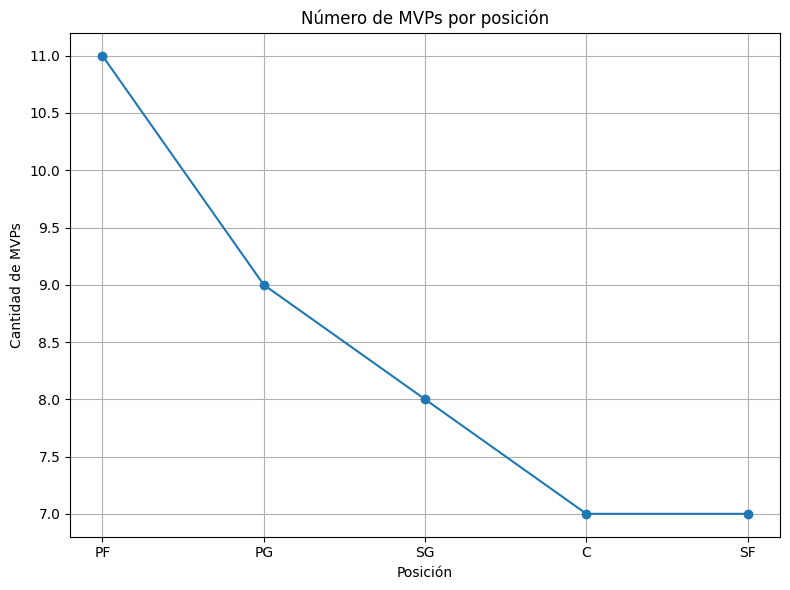


Gráfica de MVPs por posición generada correctamente.


In [11]:
# Vamos a estudiar, que estadisticas son más importantes para determinar un MVP a lo largo de la historia

# Seleccionamos solo columnas relevantes para el análisis
cols_mvp = [
    'Player', 'Year', 'Team', 'Pos', 'Age', 'MVP',
    'PTS', 'FGA', 'FG', 'AST', 'TRB',
    'FG%', 'eFG%', 'W/L%', 'G', 'MP'
]

datos_mvp = datos[cols_mvp].dropna(subset=['MVP'])

# MVPs
mvps = datos_mvp[datos_mvp['MVP'] == 1]

print("\nNúmero total de MVPs en el dataset:")
print(len(mvps))

print("\nPrimeros 5 MVPs:")
print(mvps.head())


stats_clave = ['PTS', 'FGA', 'FG', 'AST', 'TRB', 'FG%', 'eFG%', 'W/L%', 'G', 'MP']

# Media por grupo MVP vs no MVP
media_mvp = datos_mvp.groupby('MVP')[stats_clave].mean()

print("\nComparativa de estadísticas (MVP=1 vs MVP=0):")
print(media_mvp)


plt.figure(figsize=(15, 10))
for i, stat in enumerate(stats_clave):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x='MVP', y=stat, data=datos_mvp)
    plt.title(stat)
plt.tight_layout()
plt.show()

print("\nBoxplots de estadísticas comparando MVP vs no MVP generados correctamente.")



#posiciones con mas MVPS

mvp_pos = mvps['Pos'].value_counts()

print("\nNúmero de MVPs por posición:")
print(mvp_pos)

# Gráfica de línea (estilo TFM)
plt.figure(figsize=(8, 6))
plt.plot(mvp_pos.index, mvp_pos.values, marker='o', linestyle='-')
plt.title("Número de MVPs por posición")
plt.xlabel("Posición")
plt.ylabel("Cantidad de MVPs")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nGráfica de MVPs por posición generada correctamente.")



MVPs por año (verificación de un MVP por año):
Year
1980.0    1
1981.0    1
1982.0    1
1983.0    1
1984.0    1
dtype: int64

Estadísticas promedio de MVPs por década:
                 PTS    FGA     FG       AST       TRB       FG%      eFG%  \
Decada                                                                       
1980-1989  26.510000  19.14   9.98  6.290000  9.890000  0.522100  0.529900   
1990-1999  27.470000  19.84  10.15  5.110000  8.560000  0.511900  0.524700   
2000-2009  24.940000  18.42   9.10  5.900000  8.720000  0.497800  0.524800   
2010-2021  28.341667  19.45   9.85  7.391667  8.116667  0.509083  0.564833   

               W/L%          G         MP  
Decada                                     
1980-1989  0.728100  80.300000  38.280000  
1990-1999  0.770200  77.300000  38.010000  
2000-2009  0.737800  79.000000  38.380000  
2010-2021  0.745583  74.583333  35.416667  


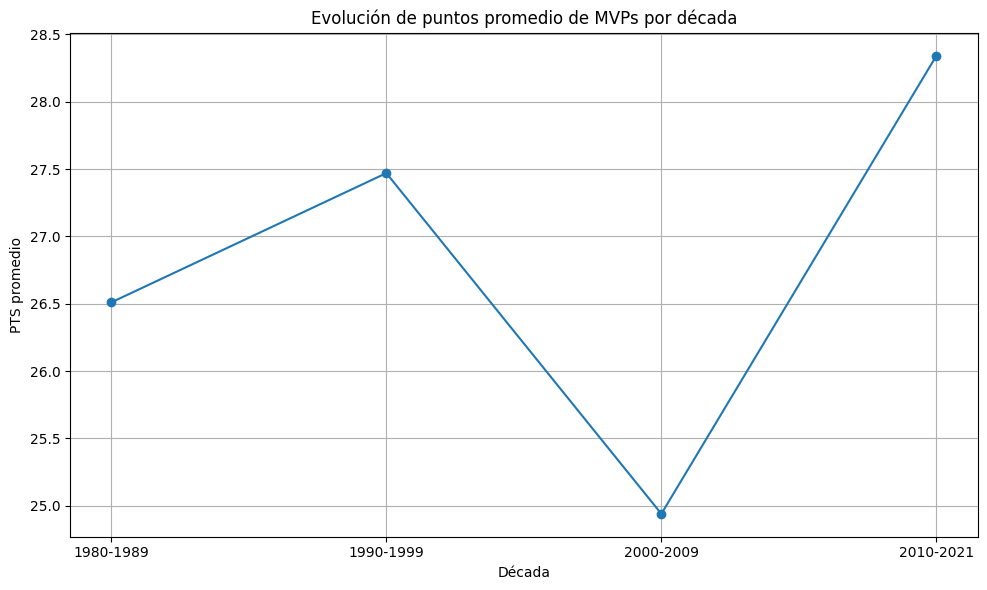


Gráfica de evolución de puntos promedio de MVPs generada correctamente.


In [12]:
#Evolucion historica de los MVPs 
mvps_por_anyo = mvps.groupby('Year').size()

print("\nMVPs por año (verificación de un MVP por año):")
print(mvps_por_anyo.head())


# Primero asignamos la década como antes
datos_mvp['Decada'] = datos_mvp['Year'].apply(asignar_decada)

# Promedio de estadísticas de MVPs por década
mvp_stats_decada = datos_mvp[datos_mvp['MVP']==1].groupby('Decada')[stats_clave].mean()

print("\nEstadísticas promedio de MVPs por década:")
print(mvp_stats_decada)

# Gráfica ejemplo: PTS de MVPs por década
plt.figure(figsize=(10,6))
plt.plot(mvp_stats_decada.index, mvp_stats_decada['PTS'], marker='o', linestyle='-')
plt.title("Evolución de puntos promedio de MVPs por década")
plt.xlabel("Década")
plt.ylabel("PTS promedio")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nGráfica de evolución de puntos promedio de MVPs generada correctamente.")



Correlación de cada estadística con MVP:
MVP     1.000000
PTS     0.146099
FG      0.138954
FGA     0.125156
AST     0.111592
TRB     0.097726
MP      0.081089
W/L%    0.078035
G       0.045201
FG%     0.035120
eFG%    0.032992
Age     0.013660
Name: MVP, dtype: float64

Media normalizada de estadísticas (MVP=1 vs MVP=0):
          PTS       FGA        FG       AST       TRB      FG%      eFG%  \
MVP                                                                        
0   -0.007070 -0.006057 -0.006724 -0.005400 -0.004729 -0.00170 -0.001597   
1    3.018989  2.586221  2.871335  2.305928  2.019405  0.72571  0.681743   

         W/L%         G        MP       Age  
MVP                                          
0   -0.003776 -0.002187 -0.003924 -0.000661  
1    1.612507  0.934024  1.675620  0.282278  


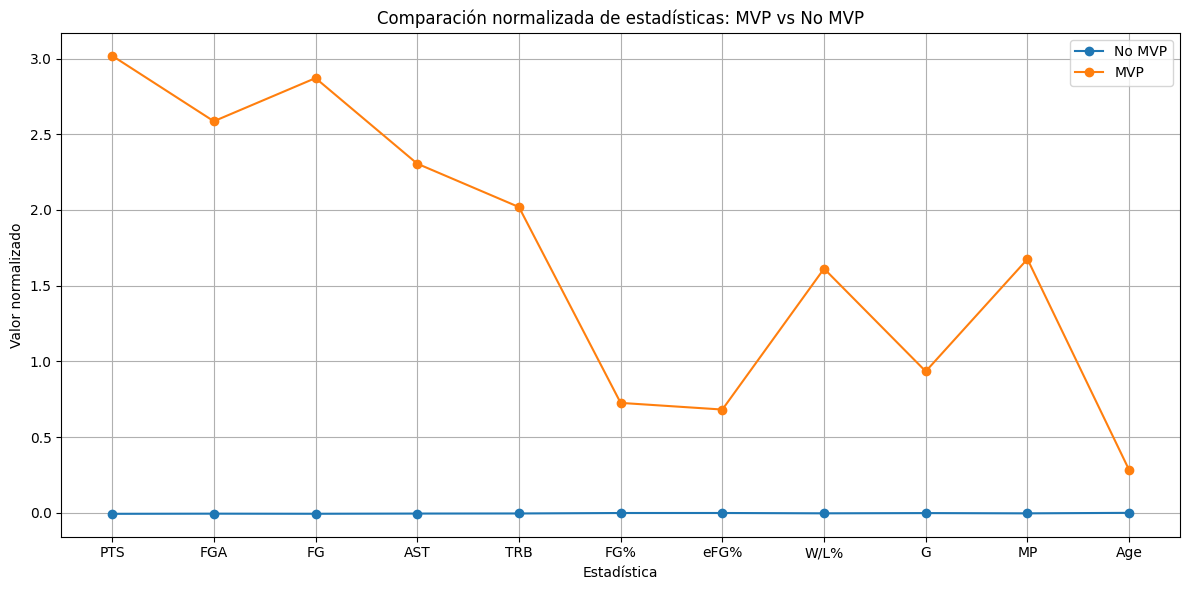


Gráfica comparativa MVP vs No MVP generada correctamente.


In [13]:
# ¿Qué estadísticas son más importantes para que un jugador sea MVP?
stats_clave = [
    'PTS', 'FGA', 'FG', 'AST', 'TRB',
    'FG%', 'eFG%', 'W/L%',
    'G', 'MP', 'Age'
]

# Dataset solo con columnas necesarias
datos_corr = datos_mvp[['MVP'] + stats_clave].dropna()

# Correlación con MVP
corr_mvp = datos_corr.corr()['MVP'].sort_values(ascending=False)

print("\nCorrelación de cada estadística con MVP:")
print(corr_mvp)


# Normalizamos estadísticas
scaler = StandardScaler()
datos_norm = datos_corr.copy()
datos_norm[stats_clave] = scaler.fit_transform(datos_corr[stats_clave])

# Media por grupo MVP
media_norm = datos_norm.groupby('MVP')[stats_clave].mean()

print("\nMedia normalizada de estadísticas (MVP=1 vs MVP=0):")
print(media_norm)


plt.figure(figsize=(12, 6))

plt.plot(
    stats_clave,
    media_norm.loc[0],
    marker='o',
    label='No MVP'
)

plt.plot(
    stats_clave,
    media_norm.loc[1],
    marker='o',
    label='MVP'
)

plt.title("Comparación normalizada de estadísticas: MVP vs No MVP")
plt.xlabel("Estadística")
plt.ylabel("Valor normalizado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nGráfica comparativa MVP vs No MVP generada correctamente.")


In [14]:
# Estadiisticas de equipo

estadisticas = ["PTS", "AST", "TRB", "STL", "BLK", "TOV", "ORB", "DRB"]

for col in estadisticas:
    # Convierte a float, fuerza errores a NaN
    datos[col] = pd.to_numeric(datos[col], errors='coerce')
    
    # Opcional: filtrar valores absurdos
    datos.loc[datos[col] > 1000, col] = np.nan  # si alguna estadística por partido > 1000, es imposible

for stat in estadisticas:
    datos[f"{stat}_x_G"] = datos[stat] * datos["G"]
# Agrupamos por equipo y año, y sumamos estadísticas de interés
team_stats = (
    datos.groupby(["Team", "Year"])
    .agg(
        total_games=("G", "max"),
        team_PTS=("PTS_x_G", "sum"),
        team_AST=("AST_x_G", "sum"),
        team_TRB=("TRB_x_G", "sum"),
        team_STL=("STL_x_G", "sum"),
        team_BLK=("BLK_x_G", "sum"),
        team_TOV=("TOV_x_G", "sum"),
        team_ORB=("ORB_x_G", "sum"),
        team_DRB=("DRB_x_G", "sum")
    )
    .reset_index()
)
# Normalizamos
for stat in estadisticas:
    team_stats[f"team_{stat}_per_game"] = (
        team_stats[f"team_{stat}"] / team_stats["total_games"]
    ).round(2)

# Limpiamos columnas intermedias:
team_stats = team_stats[
    ["Team", "Year"] +
    [f"team_{s}_per_game" for s in estadisticas]
]


# # Renombramos columnas para diferenciar del jugador
# team_stats = team_stats.rename(columns={col: f"team_{col}_total" for col in estadisticas})

# Hacemos merge para añadir las columnas de equipo a cada jugador
datos = datos.merge(team_stats, on=['Team', 'Year'], how='left')


ejemplo = datos[(datos["Team"] == "Cleveland Cavaliers") & (datos["Year"] == 2010)]

print(ejemplo[[
    "Player", "PTS", "G", "team_PTS_per_game"
]].head(10))

                   Player   PTS   G  team_PTS_per_game
17945       Daniel Gibson   6.3  56             115.46
17946         Danny Green   2.0  20             115.46
17947        J.J. Hickson   8.5  81             115.46
17948  Zydrunas Ilgauskas   7.4  64             115.46
17949        LeBron James  29.7  76             115.46
17950      Antawn Jamison  18.7  66             115.46
17951        Jamario Moon   4.9  61             115.46
17952    Shaquille O'Neal  12.0  53             115.46
17953      Anthony Parker   7.3  81             115.46
17954           Leon Powe   4.0  20             115.46


In [15]:
# Coomparación de la influencia de los jugadores extranjeros a lo largo de la historia
# Se hace este filtrado previo ya que hay algunos americanos que no pasaron por el college y este dataset los marca como extranjeros

datos['posible_extranjero'] = (datos['Colleges'] == 'Not American').astype(int)

americanos_sin_college = [
    'LeBron James',
    'Kobe Bryant',
    'Kevin Garnett',
    'Tracy McGrady',
    'Dwight Howard',
    'Amar\'e Stoudemire',
    'Shaquille O\'Neal',
    'Moses Malone',
    'Jermaine O\'Neal',
    'J.R. Smith',
    'Darius Miles',
    'Travis Outlaw',
    'Leon Smith',
    'Sebastian Telfair',
    'Terrance Ferguson',
    'Amir Johnson',
    'Kendrick Perkins',
    'Darius Bazley',
    'Monta Ellis',
    'Dorell Wright',
    'Al Harrington',
    'Martell Webster',
    'Darryl Dawkins',
    'Al Jefferson',
    'C.J. Miles',
    'Tyson Chandler',
    'Eddy Curry',
    'Jeremy Tyler',
    'Andrew Bynum',
    'Anfernee Simons',
    'Bill Willoughby',
    'Brandon Jennings',
    'Brian Bowen',
    'DeShawn Stevenson',
    'Gerald Green',
    'Jackie Butler',
    'Josh Smith',
    'Kenyon Martin Jr.',
    'Killian Hayes',
    'Korleone Young',
    'Kwame Brown',
    'LaMelo Ball',
    'Lou Williams',
    'Shaun Livingston'

]

datos['Extranjero'] = datos['posible_extranjero']

datos.loc[
    datos['Player'].isin(americanos_sin_college),
    'Extranjero'
] = 0

datos['Extranjero'] = datos['Extranjero'].astype(int)

print(
    datos.loc[datos['Extranjero'] == 1, 'Player']
    .drop_duplicates()
    .sort_values()
    .head(20)
)

4493               Adam Mokoka
5359     Aleksandar Djordjevic
11661       Aleksej Pokusevski
11642           Alen Smailagić
4650               Alex Garcia
8312          Alexander Volkov
867               Alexey Shved
2223             Alexis Ajinça
3340          Anderson Varejão
4109            Andray Blatche
826            Andrea Bargnani
3782       Andreas Glyniadakis
4086          Andrei Kirilenko
1535           Andris Biedriņš
9367            Andrés Guibert
3439            Andrés Nocioni
1531                Ante Žižić
426          Antoine Rigaudeau
5652            Antonis Fotsis
8599          Anžejs Pasečņiks
Name: Player, dtype: object


Distribución Extranjero (0=USA, 1=Extranjero):
Extranjero
0    16667
1     1309
Name: count, dtype: int64

Proporción de jugadores extranjeros por década (%):
Decada
1980-1989     0.06
1990-1999     1.92
2000-2009     9.73
2010-2021    13.20
Name: Extranjero, dtype: float64


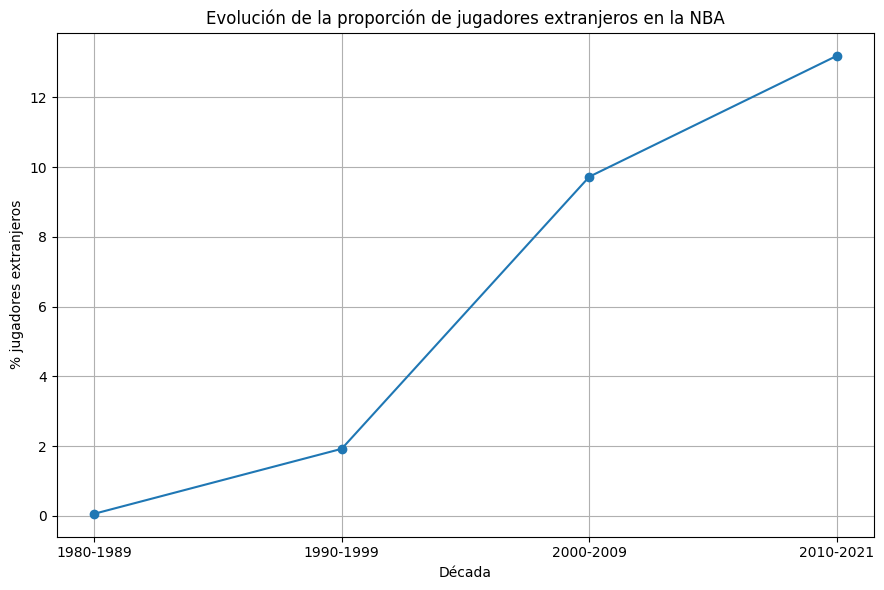


Gráfica de proporción de extranjeros por década generada.


In [16]:
# Ver el crecimiento de los no-americanos en la NBA a lo largo de las décadas
# Comprobación inicial
print("Distribución Extranjero (0=USA, 1=Extranjero):")
print(datos['Extranjero'].value_counts())

# Proporción de extranjeros por década
prop_extranjeros_decada = (
    datos
    .groupby('Decada')['Extranjero']
    .mean() * 100
)

print("\nProporción de jugadores extranjeros por década (%):")
print(prop_extranjeros_decada.round(2))
plt.figure(figsize=(9,6))
plt.plot(
    prop_extranjeros_decada.index,
    prop_extranjeros_decada.values,
    marker='o'
)
plt.title("Evolución de la proporción de jugadores extranjeros en la NBA")
plt.xlabel("Década")
plt.ylabel("% jugadores extranjeros")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nGráfica de proporción de extranjeros por década generada.")




Eficiencia media global USA vs Extranjeros:
              PTS    AST    TRB    FG%  eFG%   W/L%
Extranjero                                         
0           8.477  1.942  3.578  0.441  0.47  0.495
1           8.199  1.635  4.019  0.452  0.49  0.511


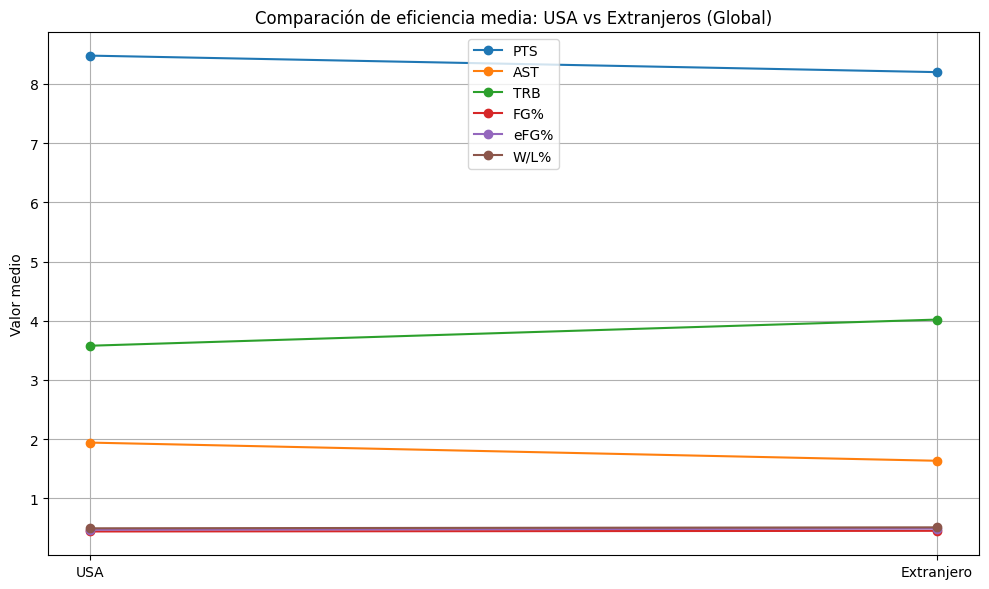


Gráfica global de eficiencia USA vs Extranjeros generada.


In [17]:
# Comparación de eficiencia USA vs Extranjeros (GLOBAL)
stats_eficiencia = ['PTS', 'AST', 'TRB', 'FG%', 'eFG%', 'W/L%']

datos_ef = datos[stats_eficiencia + ['Extranjero']].dropna()

eficiencia_global = (
    datos_ef
    .groupby('Extranjero')
    .mean()
)

print("\nEficiencia media global USA vs Extranjeros:")
print(eficiencia_global.round(3))
plt.figure(figsize=(10,6))

for col in stats_eficiencia:
    plt.plot(
        ['USA', 'Extranjero'],
        eficiencia_global[col].values,
        marker='o',
        label=col
    )

plt.title("Comparación de eficiencia media: USA vs Extranjeros (Global)")
plt.ylabel("Valor medio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nGráfica global de eficiencia USA vs Extranjeros generada.")



Eficiencia media por década y nacionalidad:
      Decada  Extranjero       PTS       AST       TRB       FG%      eFG%  \
0  1980-1989           0  9.337063  2.231621  3.778778  0.461767  0.467190   
1  1980-1989           1  2.900000  0.550000  2.250000  0.346000  0.347000   
2  1990-1999           0  8.398255  1.945433  3.586964  0.440674  0.462410   
3  1990-1999           1  8.775309  1.587654  4.153086  0.452025  0.470531   
4  2000-2009           0  8.036966  1.827270  3.557216  0.429742  0.459535   

       W/L%  
0  0.494392  
1  0.494000  
2  0.494747  
3  0.469667  
4  0.493771  


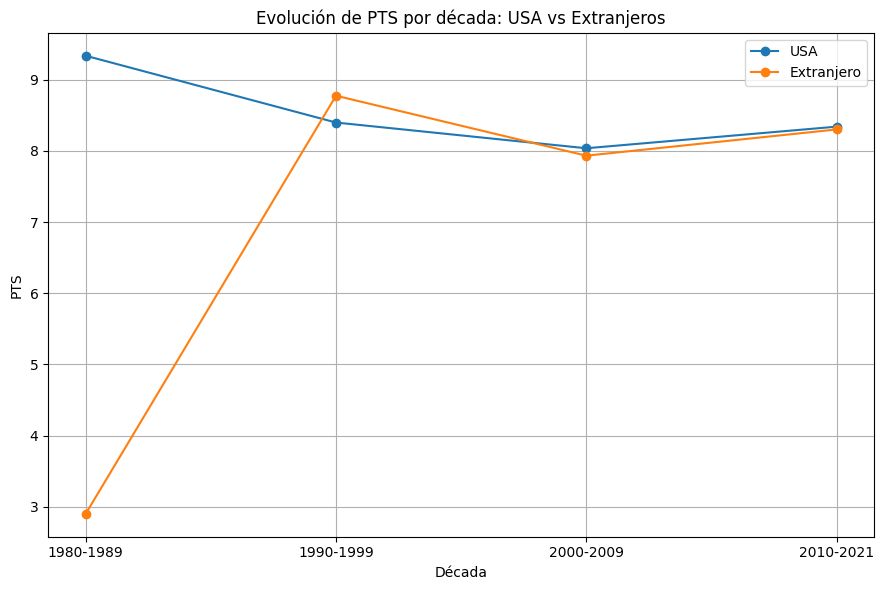

Gráfica de PTS por década generada.


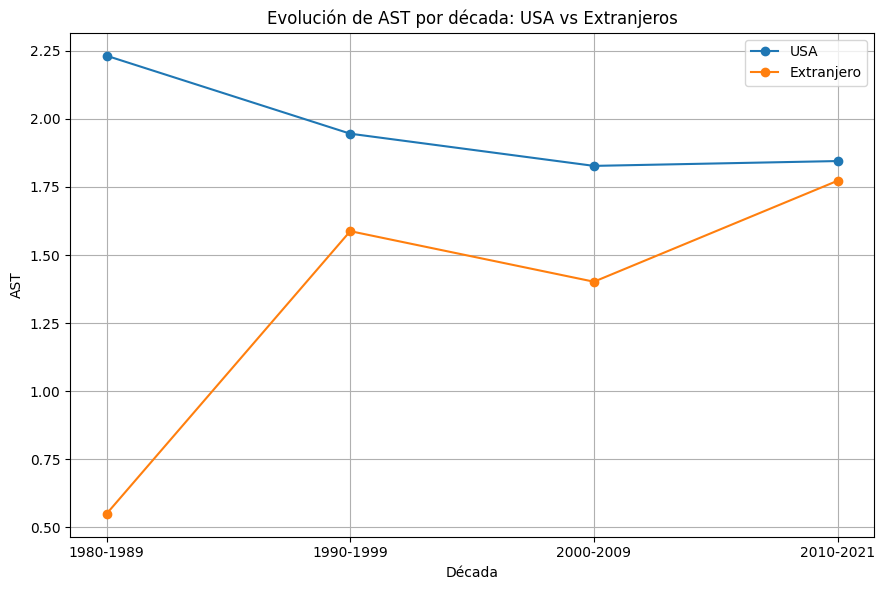

Gráfica de AST por década generada.


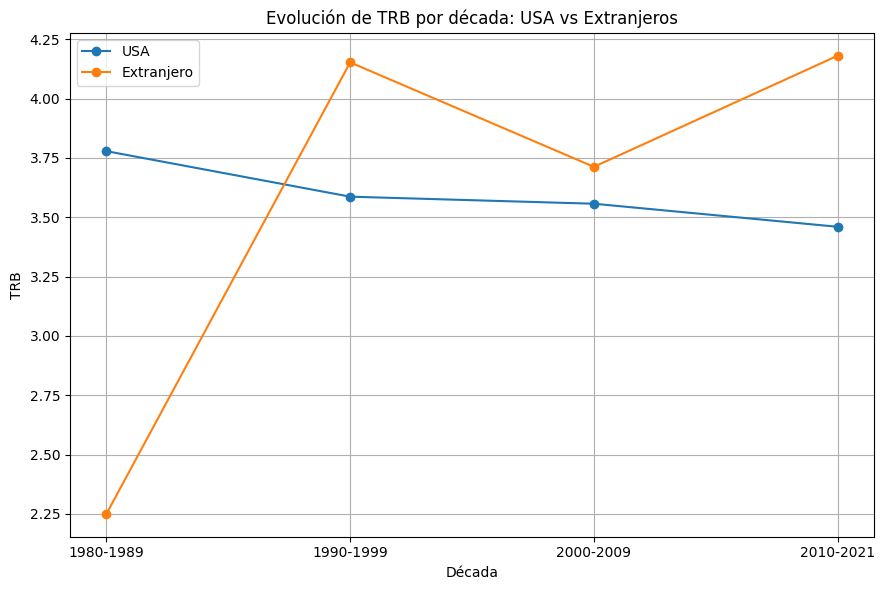

Gráfica de TRB por década generada.


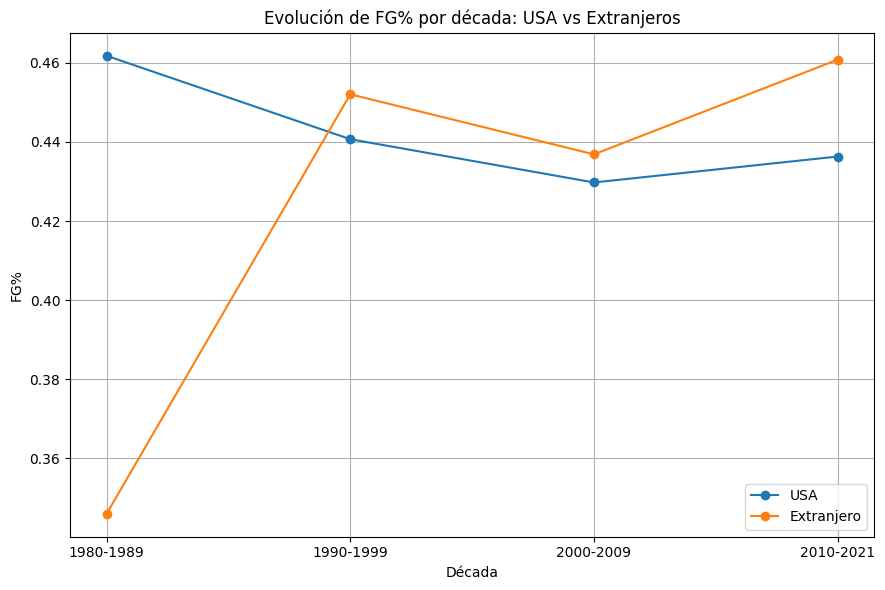

Gráfica de FG% por década generada.


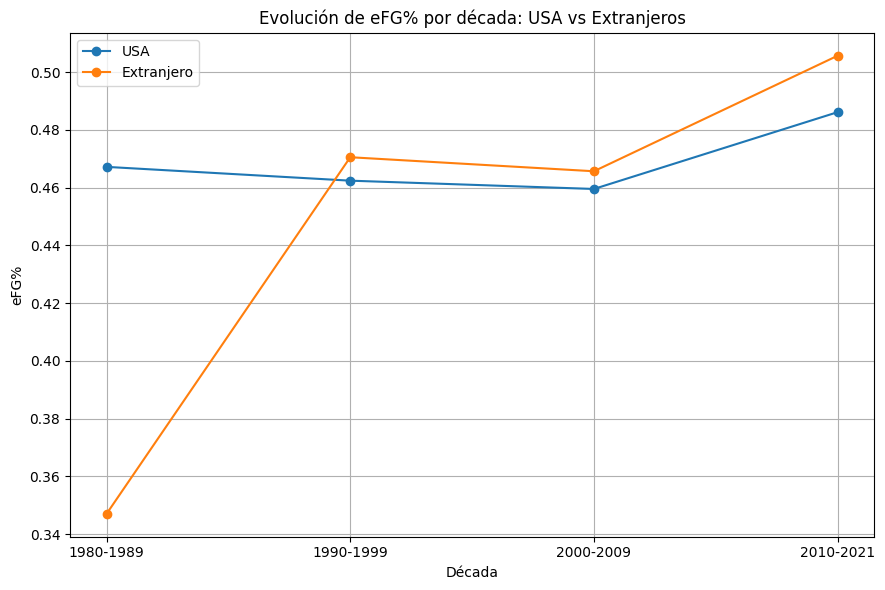

Gráfica de eFG% por década generada.


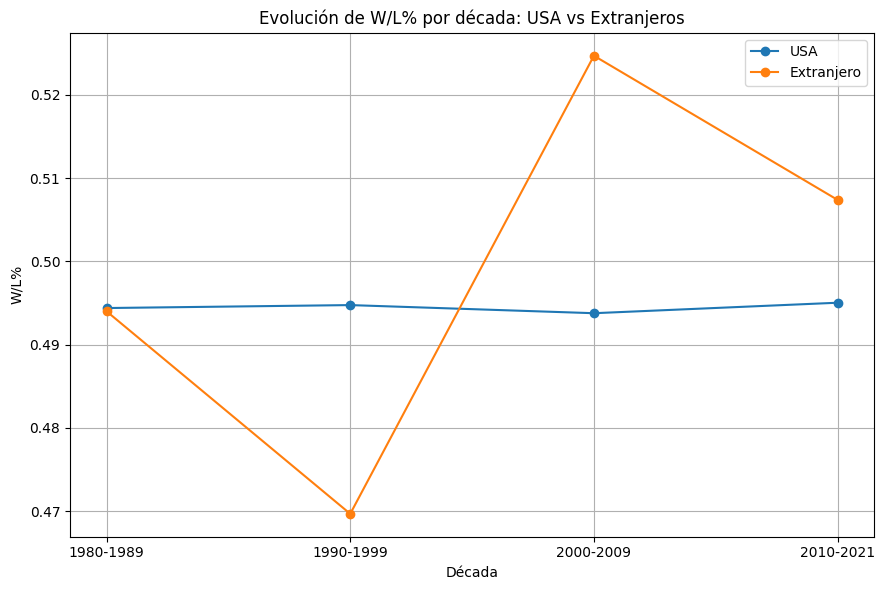

Gráfica de W/L% por década generada.


In [18]:
# Comparación de eficiencia USA vs Extranjeros POR DÉCADAS
eficiencia_decadas = (
    datos
    .groupby(['Decada', 'Extranjero'])[stats_eficiencia]
    .mean()
    .reset_index()
)

print("\nEficiencia media por década y nacionalidad:")
print(eficiencia_decadas.head())

for stat in stats_eficiencia:
    plt.figure(figsize=(9,6))

    for tipo, label in zip([0, 1], ['USA', 'Extranjero']):
        df_plot = eficiencia_decadas[eficiencia_decadas['Extranjero'] == tipo]
        plt.plot(
            df_plot['Decada'],
            df_plot[stat],
            marker='o',
            label=label
        )

    plt.title(f"Evolución de {stat} por década: USA vs Extranjeros")
    plt.xlabel("Década")
    plt.ylabel(stat)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Gráfica de {stat} por década generada.")


In [19]:
# Guardar todas las variables creadas en un dataset nuevo y limpio
variables = datos.columns.tolist()
print(variables)
# Guardar dataset limpio
datos.to_csv("nba_cleaned_final.csv", index=False, float_format="%.2f")

['Unnamed: 0', 'Player', 'Ht', 'Wt', 'Colleges', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', 'Pts Won', 'Pts Max', 'Share', 'Team', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS', 'MVP', 'Decada', 'PTS_x_G', 'AST_x_G', 'TRB_x_G', 'STL_x_G', 'BLK_x_G', 'TOV_x_G', 'ORB_x_G', 'DRB_x_G', 'team_PTS_per_game', 'team_AST_per_game', 'team_TRB_per_game', 'team_STL_per_game', 'team_BLK_per_game', 'team_TOV_per_game', 'team_ORB_per_game', 'team_DRB_per_game', 'posible_extranjero', 'Extranjero']


In [20]:
# Generar modelo predictivo

features = [
    'PTS', 'FGA', 'FG', 'AST', 'TRB',
    'FG%', 'eFG%', 'W/L%',
    'G', 'MP', 'Age'
]

X = datos[features]
y = datos['MVP']

# Eliminar filas con NaN
mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]

print("Dimensiones finales del dataset:")
print(X.shape)

print("\nDistribución de la variable MVP:")
print(y.value_counts())


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("\nDistribución MVP en train:")
print(y_train.value_counts())

print("\nDistribución MVP en test:")
print(y_test.value_counts())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nEscalado aplicado correctamente.")

Dimensiones finales del dataset:
(17976, 11)

Distribución de la variable MVP:
MVP
0    17934
1       42
Name: count, dtype: int64

Distribución MVP en train:
MVP
0    13451
1       31
Name: count, dtype: int64

Distribución MVP en test:
MVP
0    4483
1      11
Name: count, dtype: int64

Escalado aplicado correctamente.


In [21]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',  # CLAVE
    random_state=42
)

log_model.fit(X_train_scaled, y_train)

print("\nModelo de regresión logística entrenado.")

y_pred = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]

print("\nPrimeras probabilidades predichas:")
print(y_prob[:10])







Modelo de regresión logística entrenado.

Primeras probabilidades predichas:
[1.36205325e-20 2.80117070e-16 4.69758276e-19 1.10443764e-11
 8.65646019e-16 6.77248031e-11 4.97461680e-19 6.38921611e-14
 6.84652619e-10 7.78580727e-11]



Random Forest entrenado correctamente.

Matriz de confusión (Random Forest):
[[4472   11]
 [   6    5]]


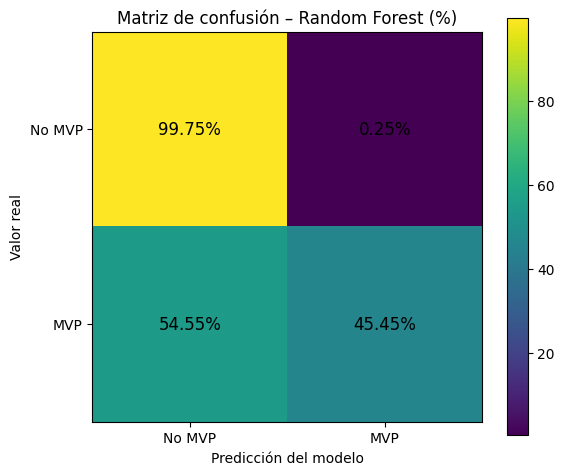


Reporte de clasificación (Random Forest):
              precision    recall  f1-score   support

           0      0.999     0.998     0.998      4483
           1      0.312     0.455     0.370        11

    accuracy                          0.996      4494
   macro avg      0.656     0.726     0.684      4494
weighted avg      0.997     0.996     0.997      4494


AUC-ROC Random Forest:
0.990144586620161

Importancia de variables – Random Forest:
PTS     0.283449
FG      0.252911
FGA     0.139848
W/L%    0.119352
MP      0.079094
AST     0.056048
TRB     0.041572
FG%     0.009267
G       0.009117
eFG%    0.007378
Age     0.001964
dtype: float64


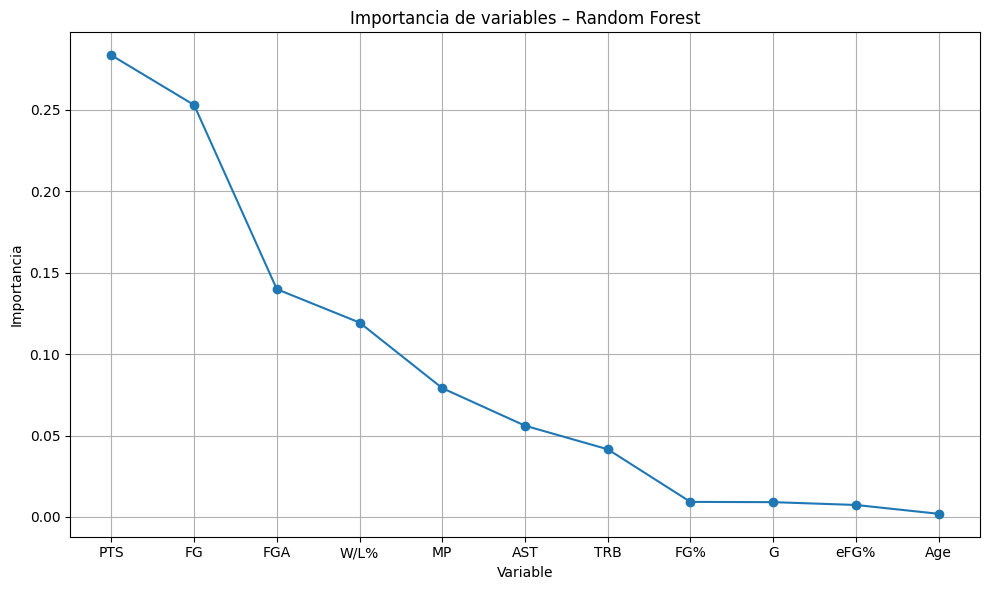


Gráfica de importancia Random Forest generada.


In [22]:
# Random forest 

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("\nRandom Forest entrenado correctamente.")

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred_rf)
print("\nMatriz de confusión (Random Forest):")
print(cm)
# Normalizar a porcentajes (por clase real)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_percent)
# Ejes y etiquetas
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No MVP', 'MVP'])
ax.set_yticklabels(['No MVP', 'MVP'])
ax.set_xlabel("Predicción del modelo")
ax.set_ylabel("Valor real")
ax.set_title("Matriz de confusión – Random Forest (%)")

# Mostrar valores en cada celda
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        ax.text(
            j, i,
            f"{cm_percent[i, j]:.2f}%",
            ha="center",
            va="center",
            fontsize=12
        )

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("\nReporte de clasificación (Random Forest):")
print(classification_report(y_test, y_pred_rf, digits=3))

print("\nAUC-ROC Random Forest:")
print(roc_auc_score(y_test, y_prob_rf))


rf_importances = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values(ascending=False)

print("\nImportancia de variables – Random Forest:")
print(rf_importances)

plt.figure(figsize=(10,6))
plt.plot(
    rf_importances.index,
    rf_importances.values,
    marker='o'
)
plt.title("Importancia de variables – Random Forest")
plt.xlabel("Variable")
plt.ylabel("Importancia")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nGráfica de importancia Random Forest generada.")




XGBoost entrenado correctamente.

Matriz de confusión (XGBoost):

Matriz de confusión (XGBoost):
[[4475    8]
 [   6    5]]


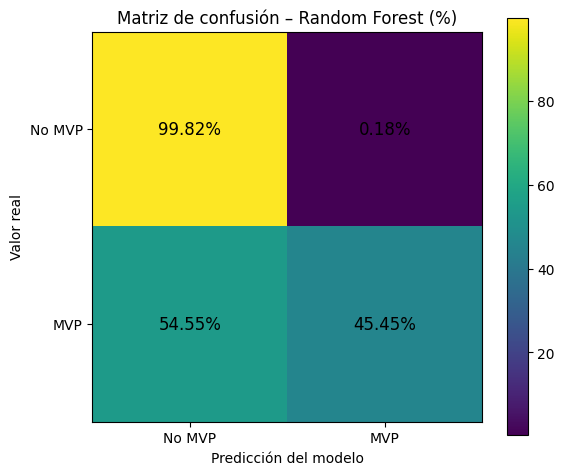


Reporte de clasificación (XGBoost):
              precision    recall  f1-score   support

           0      0.999     0.998     0.998      4483
           1      0.385     0.455     0.417        11

    accuracy                          0.997      4494
   macro avg      0.692     0.726     0.708      4494
weighted avg      0.997     0.997     0.997      4494


AUC-ROC XGBoost:
0.9865552694015777

Importancia de variables – XGBoost:
PTS     0.773387
FG      0.136774
W/L%    0.026372
FGA     0.018987
AST     0.012829
G       0.009418
TRB     0.006907
eFG%    0.004275
Age     0.004215
MP      0.003879
FG%     0.002958
dtype: float32


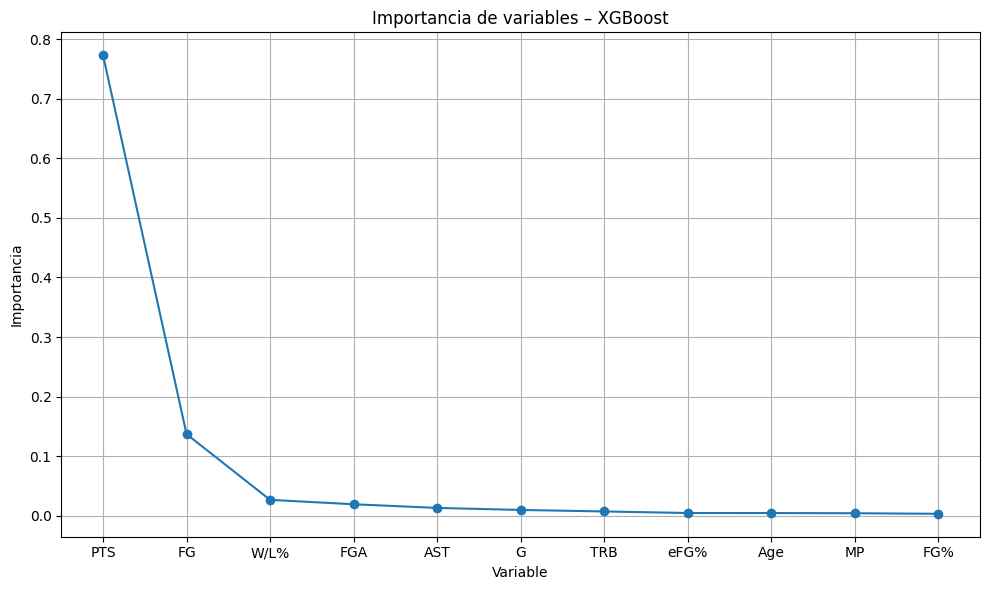


Gráfica de importancia XGBoost generada.


In [23]:
# XGBoost

from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # CLAVE
    eval_metric='auc',
    random_state=42
)

xgb_model.fit(X_train, y_train)

print("\nXGBoost entrenado correctamente.")


y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\nMatriz de confusión (XGBoost):")

cm = confusion_matrix(y_test, y_pred_xgb)
print("\nMatriz de confusión (XGBoost):")
print(cm)
# Normalizar a porcentajes (por clase real)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_percent)
# Ejes y etiquetas
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No MVP', 'MVP'])
ax.set_yticklabels(['No MVP', 'MVP'])
ax.set_xlabel("Predicción del modelo")
ax.set_ylabel("Valor real")
ax.set_title("Matriz de confusión – Random Forest (%)")

# Mostrar valores en cada celda
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        ax.text(
            j, i,
            f"{cm_percent[i, j]:.2f}%",
            ha="center",
            va="center",
            fontsize=12
        )

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()
print("\nReporte de clasificación (XGBoost):")
print(classification_report(y_test, y_pred_xgb, digits=3))

print("\nAUC-ROC XGBoost:")
print(roc_auc_score(y_test, y_prob_xgb))

xgb_importances = pd.Series(
    xgb_model.feature_importances_,
    index=features
).sort_values(ascending=False)

print("\nImportancia de variables – XGBoost:")
print(xgb_importances)

plt.figure(figsize=(10,6))
plt.plot(
    xgb_importances.index,
    xgb_importances.values,
    marker='o'
)
plt.title("Importancia de variables – XGBoost")
plt.xlabel("Variable")
plt.ylabel("Importancia")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nGráfica de importancia XGBoost generada.")
